# Training example of MOF-NET.

Training for prediction of hydrogen working capacity between 100 bar and 5 bar.

### Check available GPUs and set a GPU

In [1]:
!nvidia-smi

Sat Jan 28 19:36:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 462.59       Driver Version: 462.59       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 305... WDDM  | 00000000:F3:00.0 Off |                  N/A |
| N/A   55C    P0    10W /  N/A |    103MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
import tensorflow.keras as keras

tf.config.list_physical_devices('GPU')

[]

### Import desired libraries

In [5]:
import pickle
from pathlib import Path
from collections import defaultdict
from itertools import cycle, permutations
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Import MOF-NET

In [6]:
from mofnet import DataLoader, MOFNet

In [10]:
data_loader = DataLoader.from_state("data_loader_state-20200116.npz")

# This hash dicts map budilding block names to unique index.
topo_hash = data_loader.topo_hash
node_hash = data_loader.node_hash
edge_hash = data_loader.edge_hash

print(edge_hash.keys())
print(edge_hash.values())

data_loader.key2index('pcu+N10+E8')

dict_keys(['E117', 'E103', 'E187', 'E2', 'E138', 'E73', 'E217', 'E91', 'E79', 'E128', 'E171', 'E195', 'E172', 'E223', 'E23', 'E90', 'E193', 'E111', 'E122', 'E222', 'E31', 'E220', 'E86', 'E77', 'E184', 'E64', 'E234', 'E166', 'E207', 'E83', 'E110', 'E173', 'E204', 'E164', 'E208', 'E216', 'E26', 'E114', 'E34', 'E3', 'E134', 'E96', 'E13', 'E210', 'E38', 'E22', 'E107', 'E198', 'E179', 'E225', 'E5', 'E161', 'E185', 'E231', 'E211', 'E170', 'E66', 'E158', 'E65', 'E196', 'E52', 'E130', 'E105', 'E169', 'E4', 'E30', 'E61', 'E162', 'E35', 'E192', 'E226', 'E59', 'E153', 'E80', 'E58', 'E146', 'E101', 'E148', 'E48', 'E181', 'E1', 'E229', 'E142', 'E163', 'E154', 'E159', 'E89', 'E126', 'E143', 'E6', 'E63', 'E49', 'E140', 'E21', 'E82', 'E167', 'E27', 'E20', 'E33', 'E186', 'E99', 'E183', 'E112', 'E203', 'E135', 'E149', 'E218', 'E213', 'E113', 'E55', 'E56', 'E36', 'E174', 'E165', 'E37', 'E19', 'E53', 'E137', 'E46', 'E155', 'E95', 'E14', 'E230', 'E224', 'E93', 'E40', 'E141', 'E68', 'E100', 'E176', 'E151', 

array([144,  10,  -1,  -1,   8,  -1,  -1])

### Set name of training

In [8]:
training_name = "cycle_tot"

In [9]:
!mkdir $training_name

### Load working capacity data

In [12]:
# bar unit.
pressures = [
  1, 2, 5, 10, 20, 30, 35, 40, 50, 60, 70, 80, 90, 100
]

names = ["key"] + [str(p) for p in pressures]

gcmc_data_dir = "./"

uptake_data_paths = [
    gcmc_data_dir+"cycle_tot.txt",
]

# Hydrogen working capacity
wc_data_list = []
for path in uptake_data_paths:
    data = pd.read_table(path, index_col=0, header=None, names=names, sep="\s+")
    data = data["100"] - data["5"]
    wc_data_list.append(data)
wc_data = pd.concat(wc_data_list)

In [13]:
[len(data) for data in wc_data_list]

[132209]

### Prepare dataset

In [19]:
# Normalize working capacity.
data = wc_data.copy() / 100.0
# shuffle.
data = data.sample(frac=1)
data.describe()

count    132209.000000
mean          0.290940
std           0.085850
min           0.000000
25%           0.271731
50%           0.321339
75%           0.347026
max           0.406112
dtype: float64

In [20]:
# Extract maximum values.
max_wc_dict = defaultdict(lambda: (None, -1.0))

for idx, wc in wc_data.items():
    topo = idx.split("+")[0]
    if max_wc_dict[topo][1] < wc:
        max_wc_dict[topo] = (idx, wc)

count    1573.000000
mean        0.348041
std         0.052346
min         0.000000
25%         0.341570
50%         0.360860
75%         0.375729
max         0.406112
dtype: float64

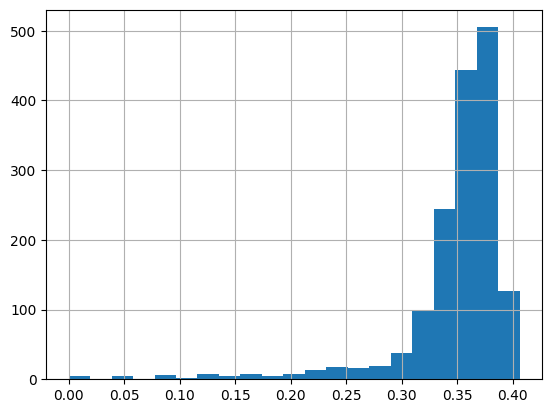

In [21]:
top_data = data.loc[[v[0] for v in max_wc_dict.values()]]
top_data.hist(bins=21)

top_data.describe()

In [22]:
# Remove top data from dataset
data.drop(index=top_data.index, inplace=True)
data.describe()

count    130636.000000
mean          0.290252
std           0.085944
min           0.000000
25%           0.270619
50%           0.320820
75%           0.346472
max           0.404647
dtype: float64

In [23]:
# Extract training data.
n_data = len(data)
n_train = int(n_data * 0.9)

# Add top data to training set.
train_data = pd.concat([top_data, data.iloc[:n_train]])
train_data.describe()

count    119145.000000
mean          0.291012
std           0.085851
min           0.000000
25%           0.271872
50%           0.321415
75%           0.347111
max           0.406112
dtype: float64

In [24]:
# Make test set.
test_data = data.iloc[n_train:]

# Remove unseen topologies.
#seen_topo = set([v.split("+")[0] for v in train_data.index])
#mask = [v.split("+")[0] in seen_topo for v in test_data.index]
#test_data = test_data[mask]

In [25]:
# Save train and test index.
with open("%s/train_data_index.txt"%training_name, "w") as f:
    for k in train_data.index:
        f.write(k+"\n")
        
# Save train and test index.
with open("%s/test_data_index.txt"%training_name, "w") as f:
    for k in test_data.index:
        f.write(k+"\n")

#### Apply resampling

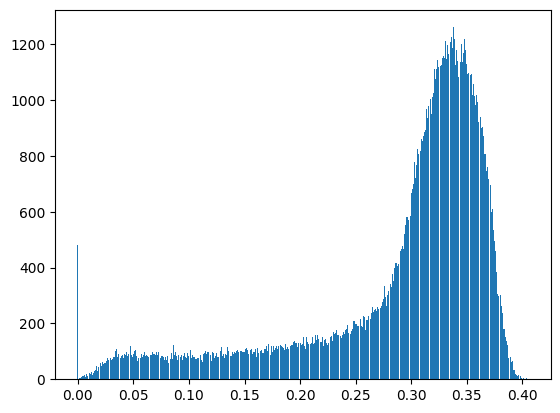

In [26]:
# Make histogram dict by value.
hist_dict = defaultdict(lambda: 0)

bin_size = 0.001
for v in train_data:
    hist_dict[int(v/bin_size)] += 1

# Plot result.
sorted_hist_dict = sorted(hist_dict.items(), key=lambda x: x[0])
plt.bar(np.arange(len(sorted_hist_dict))*bin_size, [v[1] for v in sorted_hist_dict], width=0.9*bin_size)
plt.show()

In [27]:
choice_prob = np.array([1 / hist_dict[int(v/bin_size)] for v in train_data])
choice_prob = choice_prob / np.sum(choice_prob)

<AxesSubplot: >

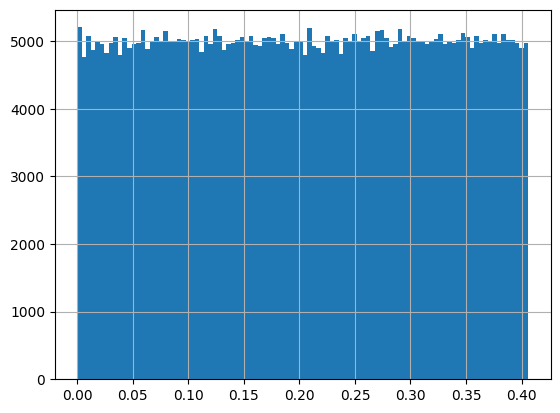

In [28]:
resampled_train_data = train_data.sample(n=500000, weights=choice_prob, replace=True)
resampled_train_data.hist(bins=100)

In [29]:
not_included_keys = list(set(train_data.index) - set(resampled_train_data.index))
len(not_included_keys)

22614

<AxesSubplot: >

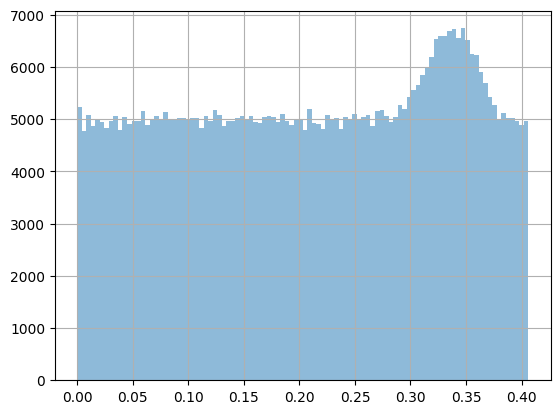

In [30]:
train_data = pd.concat([
    resampled_train_data,
    train_data.loc[not_included_keys]
]).sample(frac=1)

train_data.hist(bins=100, alpha=0.5)

### Prepare training loop

In [31]:
step = 0

# Load data loader.
data_loader = DataLoader.from_state("data_loader_state-20200116.npz")

# Make TF dataset from the data.
train_set = data_loader.make_dataset(
    np.array(train_data.index, dtype=str),
    np.array(train_data),
    batch_size=128,
)

test_set = data_loader.make_dataset(
    np.array(test_data.index, dtype=str),
    np.array(test_data),
    batch_size=128,
)

test_bulk = data_loader.make_dataset(
    np.array(test_data.index, dtype=str),
    np.array(test_data),
    batch_size=1000,
    repeat=False,
    shuffle=False,
)

train_set_iter = iter(train_set)
test_set_iter = iter(test_set)

min_mse = 1e30
min_step = 0
loss_val_list = []

optimizer = tf.optimizers.Adam()

summray_dir = "%s/summary" % training_name

summary_writer_train = tf.summary.create_file_writer("%s/train" % summray_dir)
summary_writer_test = tf.summary.create_file_writer("%s/test" % summray_dir)

In [32]:
# Make MOF-NET and the graph.
tf.summary.trace_on(graph=True, profiler=True)

mofnet = MOFNet()
mofnet.initialize_weights()

with summary_writer_train.as_default():
    tf.summary.trace_export(
        name="initilize_mofnet",
        profiler_outdir=".",
        step=0
    )

Instructions for updating:
use `tf.profiler.experimental.start` instead.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Instructions for updating:
`tf.python.eager.profiler` has deprecated, use `tf.profiler` instead.
Instructions for updating:
`tf.python.eager.profiler` has deprecated, use `tf.profiler` instead.


In [33]:
# Define loss and training loop.
def calculate_loss(y_true, y_pred):
    loss = tf.reduce_mean(
        tf.square(y_true-y_pred),
    )
    
    return loss
    

@tf.function
def train_step(model, x, y, optimizer):
    with tf.GradientTape() as tape:
        y_pred = model(x, training=True)
        loss = calculate_loss(y_true=y, y_pred=y_pred)
        
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    
    return y_pred, loss

In [34]:
while True:
    if step > 200000:
        break
    
    x, y = next(train_set_iter)
    y_pred, loss = train_step(mofnet, x, y, optimizer)
    
    # No print at the first step.
    if step == 0:
        step += 1
        continue
    
    if step%100 == 0:
        test_x, test_y = next(test_set_iter)
        test_y_pred = mofnet(test_x)
        
        test_loss = calculate_loss(y_true=test_y, y_pred=test_y_pred)
        
        with summary_writer_train.as_default():
            tf.summary.scalar("mofnet/loss", loss, step=step)
            
        with summary_writer_test.as_default():
            tf.summary.scalar("mofnet/loss", test_loss, step=step)
        
    if step%1000 == 0:
        mofnet.save_weights("{n:}/mofnet-{n:}-final.h5".format(n=training_name))
        
        # Calculate validation loss.
        y_true_list = []
        y_pred_list = []
        acc_test_loss = 0
        n_test_loss = 0
        for test_x, test_y in test_bulk:
            test_y_pred = mofnet(test_x)
            test_loss = calculate_loss(y_true=test_y, y_pred=test_y_pred)
            
            acc_test_loss += test_loss
            n_test_loss += 1

        loss_val = (acc_test_loss/n_test_loss).numpy().item()
        loss_val_list.append(loss_val)

        print("[{:d}] Loss Val: {:7.4f}, MIN MSE ({:d}): {:.4f}".format(step, loss_val, min_step, min_mse))
        if loss_val < min_mse:
            min_step = step
            print("New MIN MSE: %7.4f" % loss_val)
            mofnet.save_weights("{n:}/mofnet-{n:}-min.h5".format(n=training_name))
            min_mse = loss_val
            
    step += 1

KeyboardInterrupt: 

In [27]:
mofnet.load_weights("cycle_tot/mofnet-{n:}-min.h5".format(n=training_name))

In [28]:
y_pred = []
for x, y in test_bulk:
    _y = mofnet(x)
    y_pred += _y.numpy().reshape(-1).tolist()
y_pred = np.array(y_pred)

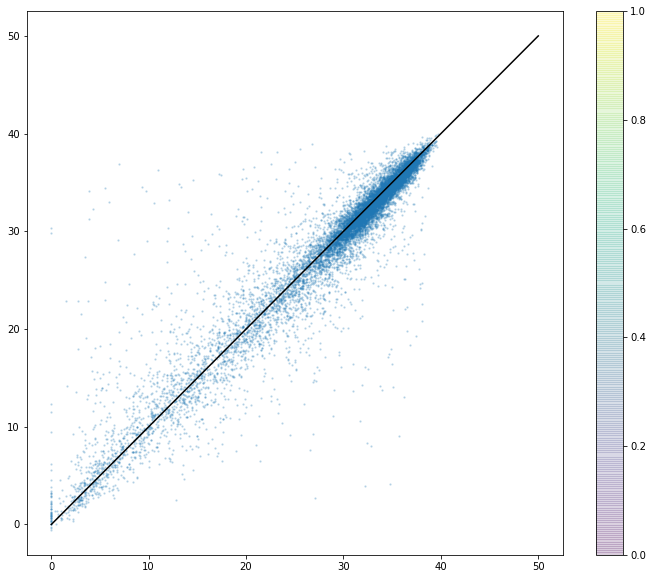

In [29]:
x = test_data*100
y = np.array(y_pred)*100

plt.figure(figsize=(12, 10))
plt.scatter(x, y,
            #c=c, 
            s=2, alpha=0.2)
plt.plot([0, 50], [0, 50], c="black")
plt.colorbar()
plt.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


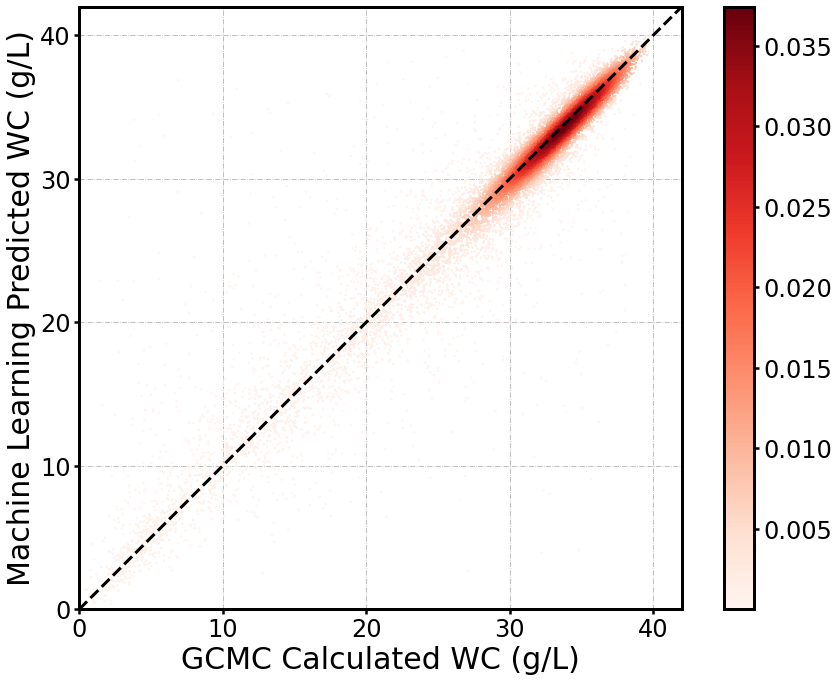

In [33]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import gaussian_kde

#Draw parity plot

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size']=24
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 2.5
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 2.5
mpl.rcParams['axes.linewidth'] = 3
plt.rcParams['axes.axisbelow'] = True

fig, ax = plt.subplots(1,1, figsize=(13, 10))

T = np.array([x, y])
color = gaussian_kde(T)(T)

im = plt.scatter(x,y, c=color, cmap='Reds',s=2)
ax.set_aspect('equal')

plt.plot([0, 42], [0, 42], c="black", linewidth=3, linestyle='--')
plt.colorbar(im)

plt.yticks([0,10,20,30,40],fontsize=24)
plt.xticks([0,10,20,30,40], fontsize=24)

plt.tick_params(axis='both', labelsize=24)

plt.tick_params(labelsize=24)

plt.xlabel('GCMC Calculated WC (g/L)', fontsize = 30)
plt.ylabel('Machine Learning Predicted WC (g/L)', fontsize = 30)

plt.grid(axis='both',linestyle='-.')

plt.xlim(xmin=0,xmax=42)
plt.ylim(ymin=0,ymax=42)

plt.tight_layout()